## Test the computational complexity of the different algorithms

ie. compare how the different algorithms scale with the number of datapoints (and maybe later also with dimension, we only have data sets of dimension 2 and 3 though). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_spiral_data, load_aggregation_data, load_birch1_data, load_birch3_data, load_compound_data, load_flame_data, load_pathbased_data, load_sets_data, scale_data, load_fuzzy_data
from timeit import default_timer as timer 
from clustertools.models.distance import KMeans, Regspace
from clustertools.models.similarity import SpectralClustering, HierarchicalClustering
from clustertools.models.density import MeanShift, DBSCAN
from clustertools.models.fuzzy import FuzzyCMeans
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#set font sizes for matplotlib plots and seaborn plots
fontsizeset = 20
rc={'axes.labelsize': fontsizeset, 'font.size': fontsizeset, 'legend.fontsize': fontsizeset, 'axes.titlesize': fontsizeset,'xtick.labelsize': fontsizeset, 'ytick.labelsize': fontsizeset}
sns.mpl.rcParams.update(rc)

In [3]:
spiral=load_spiral_data(scale = 'True')
aggr=load_aggregation_data(scale = 'True')
compound = load_compound_data(scale = 'True')
fuzzy = load_fuzzy_data(scale = 'True')
fuzzy = fuzzy[np.arange(0,2309,2),:]
pathbased = load_pathbased_data(scale = 'True')
dataset = [spiral, aggr, compound, fuzzy, pathbased]

very ugly function below calling all the different algorithms and using them on a test data set with different number of datapoints. 

In [4]:
def computational_complexity(datapoints, data):
    time = np.zeros((7, np.shape(datapoints)[0]))
    #2 dimensions only for now
    for i,nbr in enumerate(datapoints):
        #fuzzy c means
        start_time = timer()
        alg = FuzzyCMeans(data[np.random.randint(1,  np.shape(data)[0], nbr),:], c=4, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[0,i]=time_taken 
        #mean shift
        start_time = timer()
        alg = MeanShift(data[np.random.randint(1,  np.shape(data)[0], nbr),:], verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[1,i]=time_taken 
        #k means
        start_time = timer()
        alg = KMeans(data[np.random.randint(1,  np.shape(data)[0], nbr),:],4, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[2,i]=time_taken 
        #RegSpace
        start_time = timer()
        alg = Regspace(data[np.random.randint(1,  np.shape(data)[0], nbr),:],10,.3, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[3,i]=time_taken 
        #Spectral Clustering
        if nbr<2000:
            start_time = timer()
            alg = SpectralClustering(data[np.random.randint(1,  np.shape(data)[0], nbr),:],5,similarity_measure='gaussian',bandwidth=.3,laplacian='normalized', verbose=False)
            alg.fit()
            time_taken = timer() - start_time
            time[4,i]=time_taken
        else: 
            time[4,i]=float('nan')
        #dbscan
        start_time = timer()
        alg = DBSCAN(data[np.random.randint(1,  np.shape(data)[0], nbr),:],eps=0.03, minPts=10, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[5,i]=time_taken
        #hierarchical
        if nbr<2000:
            start_time = timer()
            alg = HierarchicalClustering(data[np.random.randint(1,  np.shape(data)[0], nbr),:],k=3, verbose=False)
            alg.fit()
            time_taken = timer() - start_time
            time[6,i]=time_taken
        else: 
            time[6,i]=float('nan')
        #consensus clustering
        #affinity
        #kmeans ++
        
        
    method_label = ['Fuzzy C-Means', 'Mean Shift', 'K-Means','RegSpace','Spectral Clustering', 'DBScan','Hierarchical']                          
    return time,  method_label       

In [5]:
birch3=load_birch3_data(scale = 'True')
data= birch3[:5100,:2]
datapoints = np.arange(0, np.shape(data)[0], 500)[1:]

time, method_label = computational_complexity(datapoints, data)
#save the results, just in case
np.save('images/time', time)
np.save('images/method', method_label)   # X is an array

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem
Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem
Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


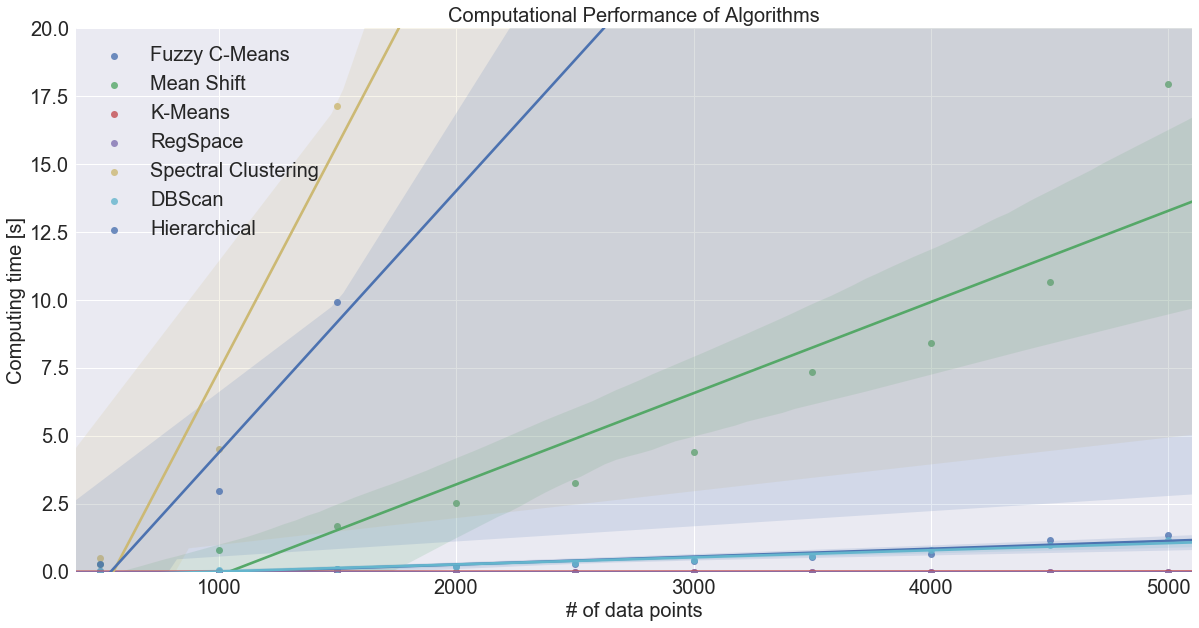

In [6]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(method_label)):
    sns.regplot(x=datapoints, y=time[i,:], ax=ax, label=method_label[i])
plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 20])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complex.png')

Maybe split the graph up into two plots, one for the faster algorithms and one for the slower ones. 

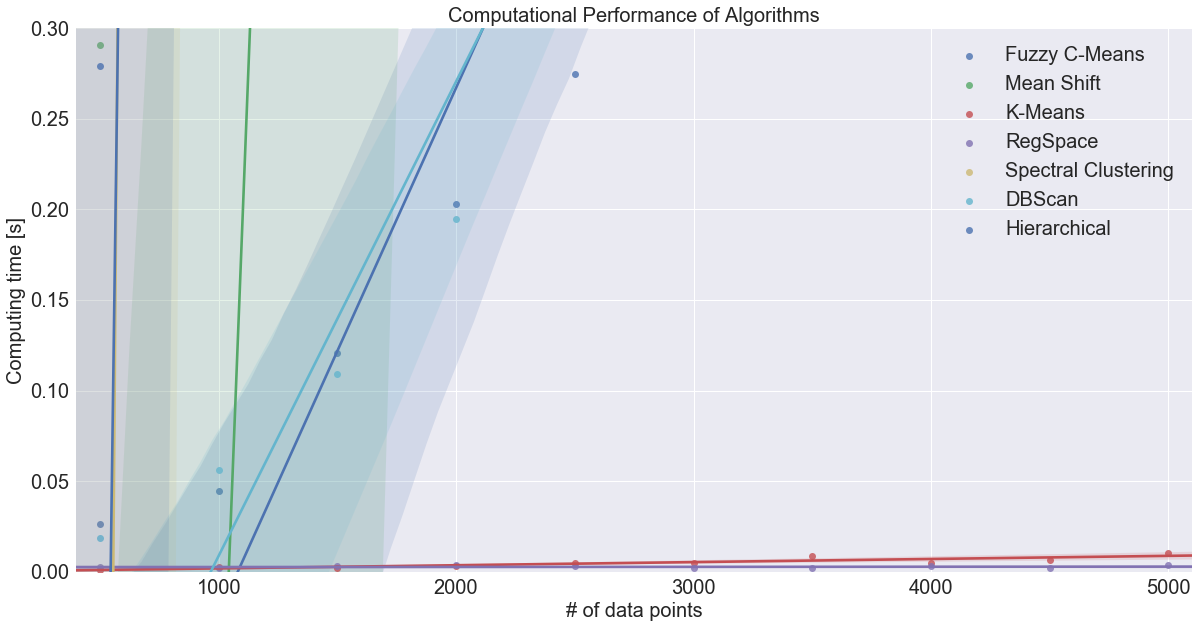

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(method_label)):
    sns.regplot(x=datapoints, y=time[i,:], ax=ax, label=method_label[i])
plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 0.3])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complex2.png')